### 文件读取

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
import matplotlib.font_manager as fm
import platform
import os

# 根据操作系统设置合适的中文字体
system = platform.system()
if system == 'Darwin':  # macOS
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC', 'PingFang HK', 'Apple Color Emoji']
elif system == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun']
else:  # Linux或其他
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'WenQuanYi Zen Hei']

# 正常显示负号
plt.rcParams['axes.unicode_minus'] = False

print(f"当前操作系统: {system}")
print(f"当前字体设置: {plt.rcParams['font.sans-serif']}")

# 定义路径
parent_dir = "生成结果"
sub_dir = "last_quadrant"
sub_dir_path = os.path.join(parent_dir, sub_dir)

# 先确保父目录存在
if not os.path.exists(parent_dir):
    os.makedirs(parent_dir)
    print(f"已创建目录: {parent_dir}")

# 检查子目录是否存在，如果不存在则创建
if not os.path.exists(sub_dir_path):
    os.makedirs(sub_dir_path)
    print(f"已创建子目录: {sub_dir_path}")
else:
    print(f"子目录已存在: {sub_dir_path}")

当前操作系统: Windows
当前字体设置: ['SimHei', 'Microsoft YaHei', 'SimSun']
子目录已存在: 生成结果\last_quadrant


In [2]:

import os
import glob

matches_analysis_dir = "生成结果/needs_analysis/"
voc_data_files = glob.glob(os.path.join(matches_analysis_dir, "*_用户需求象限分析_完整列表.txt"))
if voc_data_files:
    voc_data_path = voc_data_files[0]  # 使用找到的第一个匹配文件
else:
    voc_data_path = None
    print("未找到匹配的VOC数据文件")

# 自动搜索"生成结果/social_media/"文件夹下的文件
social_media_dir = "生成结果/social_media/"
social_media_files = glob.glob(os.path.join(social_media_dir, "View-归一化的模型结果.txt"))
if social_media_files:
    social_media_model_path = social_media_files[0]
else:
    social_media_model_path = None
    print("未找到匹配的社交媒体模型结果文件")

# 打印找到的文件路径
if voc_data_path:
    print(f"找到VOC数据文件: {voc_data_path}")
if social_media_model_path:
    print(f"找到社交媒体模型文件: {social_media_model_path}")


# 读取VOC数据（TXT格式）
def read_voc_data(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()

        # 检查文件是否表明没有匹配数据
        if "没有找到任何需求-场景匹配数据" in content or "没有找到任何" in content:
            print(f"文件 {file_path} 中没有找到任何匹配数据，将返回空DataFrame")
            # 创建只有列名的空DataFrame
            empty_df = pd.DataFrame(columns=[
                '象限', '排名', '需求名称', '重要性分数', '提及频率', 
                '文本质量', '最终得分', '综合得分'
            ])
            return empty_df

        # 提取各象限的数据
        quadrants = []

        # 匹配四个象限区域
        quadrant_pattern = r'## (第[一二三四]象限[^#]*?)(?=\n\n## |$)'
        quadrant_matches = re.findall(quadrant_pattern, content, re.DOTALL)

        for quadrant_content in quadrant_matches:
            # 提取象限标题
            title_match = re.match(r'(第[一二三四]象限[^\n]*)', quadrant_content)
            quadrant_title = title_match.group(1) if title_match else "未知象限"

            # 修正：匹配需求项目的正则表达式，适应两行格式和括号内的综合得分
            defect_pattern = r'(\d+)\. (.*?)\n\s+重要性分数: ([\d\.]+), 提及频率: ([\d\.]+), 文本质量: ([\d\.]+)\n\s+最终得分: ([\d\.]+) \(综合得分: ([\d\.]+)\)'
            defect_matches = re.findall(defect_pattern, quadrant_content, re.DOTALL)

            for defect in defect_matches:
                index, name, importance, frequency, quality, final_score, total_score = defect
                quadrants.append({
                    '象限': quadrant_title,
                    '排名': int(index),
                    '需求名称': name.strip(),
                    '重要性分数': float(importance),
                    '提及频率': float(frequency),
                    '文本质量': float(quality),
                    '最终得分': float(final_score),
                    '综合得分': float(total_score)
                })

        # 创建DataFrame
        voc_data = pd.DataFrame(quadrants)
        
        # 如果没有提取到数据，返回空DataFrame
        if len(voc_data) == 0:
            print(f"文件 {file_path} 中没有提取到需求数据，将返回空DataFrame")
            # 创建只有列名的空DataFrame
            empty_df = pd.DataFrame(columns=[
                '象限', '排名', '需求名称', '重要性分数', '提及频率', 
                '文本质量', '最终得分', '综合得分'
            ])
            return empty_df
            
        print(f"成功读取VOC数据，共{len(voc_data)}条记录")
        return voc_data
    except Exception as e:
        print(f"读取VOC数据失败: {e}")
        # 创建只有列名的空DataFrame
        empty_df = pd.DataFrame(columns=[
            '象限', '排名', '需求名称', '重要性分数', '提及频率', 
            '文本质量', '最终得分', '综合得分'
        ])
        return empty_df

# 读取社交媒体模型结果
def read_social_media_model(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        
        # 使用正则表达式提取表格内容
        pattern = r'\|\s*(.*?)\s*\|\s*(.*?)\s*\|\s*(.*?)\s*\|\s*(.*?)\s*\|\s*(.*?)\s*\|\s*(.*?)\s*\|\s*(.*?)\s*\|'
        matches = re.findall(pattern, content)
        
        # 创建DataFrame
        if matches and len(matches) > 2:  # 确保有足够的行（标题行、分隔行、数据行）
            # 跳过标题行和分隔行
            data = []
            for match in matches:
                # 跳过表头分隔行 (|---|---|)
                if not all('-' in item for item in match):
                    data.append(match)
            
            # 去掉表头
            if len(data) > 1:
                columns = ['变量', '变量类型', '系数', 'p值', '归一化系数', '归一化百分比', '显著性']
                df = pd.DataFrame(data[1:], columns=columns)  # 跳过第一行作为标题
                
                # 处理数值列
                df['系数'] = df['系数'].astype(float)
                df['p值'] = df['p值'].astype(float)
                df['归一化系数'] = df['归一化系数'].astype(float)
                df['归一化百分比'] = df['归一化百分比'].str.rstrip('%').astype(float)
                
                print(f"成功读取社交媒体模型结果，共{len(df)}条记录")
                return df
        
        print("未能从文件中提取有效内容")
        return None
    except Exception as e:
        print(f"读取社交媒体模型结果失败: {e}")
        return None

# 读取数据
voc_data = read_voc_data(voc_data_path)
social_media_model = read_social_media_model(social_media_model_path)

# 显示数据概览
if voc_data is not None:
    print("\nVOC数据概览:")
    print(voc_data.head())
    print("\nVOC数据统计:")
    print(voc_data.groupby('象限').size())
    
if social_media_model is not None:
    print("\n社交媒体模型结果概览:")
    print(social_media_model.head())
    print("\n显著变量:")
    print(social_media_model[social_media_model['显著性'] == '是'])

找到VOC数据文件: 生成结果/needs_analysis\致欧-2025-01-10之后VOC数据_用户需求象限分析_完整列表.txt
找到社交媒体模型文件: 生成结果/social_media/View-归一化的模型结果.txt
成功读取VOC数据，共80条记录
成功读取社交媒体模型结果，共2条记录

VOC数据概览:
                     象限  排名                                 需求名称   重要性分数  \
0  第一象限：核心需求区（高重要性，高频率）   1               wish it had more tiers  559.45   
1  第一象限：核心需求区（高重要性，高频率）   2        could use wheels for mobility  321.49   
2  第一象限：核心需求区（高重要性，高频率）   3  would be better if it didn't wobble  242.54   
3  第一象限：核心需求区（高重要性，高频率）   4             needs more storage space   69.79   
4  第一象限：核心需求区（高重要性，高频率）   5        could use a minimalist design    1.87   

       提及频率  文本质量  最终得分  综合得分  
0  0.189937   0.8  0.90  1.00  
1  0.109297   0.8  0.69  0.57  
2  0.082639   0.8  0.62  0.43  
3  0.025325   1.0  0.56  0.13  
4  0.000666   1.0  0.50  0.00  

VOC数据统计:
象限
第一象限：核心需求区（高重要性，高频率）     20
第三象限：潜在需求区（低重要性，低频率）     20
第二象限：基础需求区（低重要性，高频率）     20
第四象限：差异化需求区（高重要性，低频率）    20
dtype: int64

社交媒体模型结果概览:
                     变量  变量类型      系

### 建立痛点与社媒变量的关联关系

In [3]:
import os
import json
import pandas as pd
from openai import OpenAI
from time import sleep

os.environ["DASHSCOPE_API_KEY"] = "sk-2ea9416b45e04af6b6aa72d3c2ade52f"

In [4]:
def configure_openai_client():
    """配置OpenAI客户端连接到阿里云百炼"""
    import os
    from openai import OpenAI
    
    api_key = os.getenv("DASHSCOPE_API_KEY")
    if not api_key:
        # 如果环境变量中没有设置API密钥，请在此处设置
        api_key = "YOUR_API_KEY"  # 请替换为您的实际API密钥
        print("警告: 使用代码中的API密钥，建议通过环境变量设置")
    
    client = OpenAI(
        api_key=api_key,
        base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    )
    return client

# 使用qwen-max模型映射痛点到社媒变量
def map_needs_to_variables(need, social_media_variables, client):
    """
    使用qwen-max模型将痛点映射到相关的社交媒体变量
    
    Args:
        need: 未被满足的需求描述
        social_media_variables: 可用的社交媒体变量列表
        client: OpenAI客户端
    
    Returns:
        dict: 变量与关联强度的映射
    """
    import json
    from time import sleep
    
    # 构建提示词
    prompt = f"""
    你是一个产品分析专家。请分析以下消费者对产品未被满足的需求，与消费者行为变量之间的关联关系:
    
    未被满足的需求: "{need}"
    
    可选的消费者行为变量:
    {", ".join(social_media_variables)}
    
    请分析这个产品缺陷/痛点与哪些消费者行为变量最相关，并给出关联强度(0-1之间的浮点数)。
    只返回JSON格式，结构如下:
    {{
        "变量名1": 关联强度,
        "变量名2": 关联强度,
        ...
    }}
    
    请只选择最相关的2-4个变量，并按关联强度从高到低排序。
    """
    
    # 设置最大重试次数
    max_retries = 3
    retry_count = 0
    retry_delay = 2  # 初始重试延迟(秒)
    
    while retry_count < max_retries:
        try:
            # 调用qwen-max模型
            completion = client.chat.completions.create(
                model="qwen-max",  # 使用qwen-max模型
                messages=[
                    {'role': 'system', 'content': 'You are a helpful assistant specializing in product analysis.'},
                    {'role': 'user', 'content': prompt}
                ],
                response_format={"type": "json_object"}
            )
            
            # 解析返回结果
            response_content = completion.choices[0].message.content
            result = json.loads(response_content)
            return result
        
        except json.JSONDecodeError as e:
            # JSON解析错误，可能是返回格式不正确
            print(f"JSON解析错误 (尝试 {retry_count+1}/{max_retries}): {e}")
            print(f"API返回内容: {response_content if 'response_content' in locals() else 'N/A'}")
            
            retry_count += 1
            if retry_count < max_retries:
                print(f"等待 {retry_delay} 秒后重试...")
                sleep(retry_delay)
                retry_delay *= 2  # 指数退避策略
            
        except Exception as e:
            # 其他API错误
            print(f"API调用错误 (尝试 {retry_count+1}/{max_retries}): {e}")
            
            retry_count += 1
            if retry_count < max_retries:
                print(f"等待 {retry_delay} 秒后重试...")
                sleep(retry_delay)
                retry_delay *= 2  # 指数退避策略
    
    # 所有重试都失败，返回默认值
    print(f"错误: 映射痛点 '{pain_point}' 失败，所有重试都失败，使用默认值")
    if "价格敏感度" in social_media_variables:
        return {"价格敏感度": 0.8, "设计审美偏好": 0.6}
    else:
        # 使用列表中的前两个变量作为默认值
        defaults = {}
        for var in social_media_variables[:2]:
            defaults[var] = 0.7 if var == social_media_variables[0] else 0.5
        return defaults


def analyze_sentiment_with_huggingface(texts):
    """
    使用Hugging Face的预训练模型分析文本情感强度
    
    Args:
        texts: 需要分析的文本列表
    
    Returns:
        list: 情感得分列表，范围在0-1之间
    """
    try:
        from transformers import pipeline
        
        print("正在加载情感分析模型...")
        # 加载情感分析模型
        sentiment_analyzer = pipeline(
            "sentiment-analysis", 
            model="distilbert-base-uncased-finetuned-sst-2-english",
            device=-1  # 使用CPU；如果有GPU可用，可以设为0或其他适当值
        )
        print("模型加载完成，开始分析文本情感...")
        
        # 批量处理文本
        results = []
        batch_size = 16  # 设置适当的批处理大小
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            print(f"处理文本批次 {i//batch_size + 1}/{(len(texts)-1)//batch_size + 1}")
            
            # 处理文本长度限制问题
            processed_texts = []
            for text in batch_texts:
                # 截断过长的文本
                if len(text) > 512:
                    processed_text = text[:512]
                else:
                    processed_text = text
                processed_texts.append(processed_text)
            
            batch_results = sentiment_analyzer(processed_texts)
            
            for res in batch_results:
                # 使用模型的置信度分数作为情感强度
                sentiment_score = res["score"]
                results.append(sentiment_score)
        
        print(f"情感分析完成，共处理{len(texts)}条文本")
        return results
    
    except ImportError as e:
        print(f"警告: 无法导入transformers模块 - {e}")
        print("将使用随机值代替情感分析结果")
        # 如果无法导入transformers，使用随机值作为替代
        import random
        return [random.uniform(0.5, 1.0) for _ in range(len(texts))]
    
    except Exception as e:
        print(f"情感分析过程中发生错误: {e}")
        print("将使用随机值代替情感分析结果")
        import random
        return [random.uniform(0.5, 1.0) for _ in range(len(texts))]

### 计算坐标值

In [5]:
def establish_needs_relationships(voc_data, social_media_model):
    """
    使用qwen-max模型建立痛点与社媒变量的关联关系
    
    Args:
        voc_data: 包含产品未被满足的需求的DataFrame
        social_media_model: 包含社交媒体变量的DataFrame
    
    Returns:
        DataFrame: 包含需求与社媒变量关联关系的DataFrame
    """
    import pandas as pd
    from time import sleep
    
    # 配置OpenAI客户端
    try:
        client = configure_openai_client()
    except ImportError as e:
        print(f"警告: 无法导入OpenAI模块 - {e}")
        print("将使用预定义的默认值进行分析")
        client = None
    
    # 获取可用的社交媒体变量列表
    social_media_variables = social_media_model['变量'].tolist()
    
    # 为每个痛点创建关联关系
    needs_relationships = []
    
    # 处理所有记录
    for idx, row in voc_data.iterrows():            
        need = row['需求名称']
        print(f"处理需求: {need}")
        
        # 使用qwen-max模型进行映射
        if client:
            variable_mappings = map_needs_to_variables(need, social_media_variables, client)
        else:
            # 如果没有客户端，使用预定义的默认值
            variable_mappings = {"价格敏感度": 0.8, "设计审美偏好": 0.6}
        
        # 为每个映射创建一条记录
        for variable, association_strength in variable_mappings.items():
            if variable in social_media_model['变量'].values:
                var_row = social_media_model[social_media_model['变量'] == variable].iloc[0]
                transmission_coef = abs(float(var_row['归一化系数']))
                
                needs_relationships.append({
                    'need': need,
                    'variable': variable,
                    'association_strength': float(association_strength),
                    'transmission_coef': transmission_coef
                })
        
        # 添加短暂延迟，避免API调用过于频繁
        if client:
            sleep(0.5)
    
    # 转换为DataFrame
    relationships_df = pd.DataFrame(needs_relationships)
    
    # 如果结果为空，添加一些默认值
    if len(relationships_df) == 0:
        print("警告: 未能建立任何痛点与社媒变量的关联关系，使用默认值")
        for idx, row in voc_data.iterrows():
            pain_point = row['缺陷名称']
            default_variables = social_media_variables[:2] if social_media_variables else ["设计审美偏好", "价格敏感度"]
            
            for i, variable in enumerate(default_variables):
                if variable in social_media_model['变量'].values:
                    var_row = social_media_model[social_media_model['变量'] == variable].iloc[0]
                    transmission_coef = abs(float(var_row['归一化系数']))
                    
                    needs_relationships.append({
                        'need': need,
                        'variable': variable,
                        'association_strength': 0.8 if i == 0 else 0.6,
                        'transmission_coef': transmission_coef
                    })
        
        relationships_df = pd.DataFrame(needs_relationships)
    
    return relationships_df

def calculate_coordinates(voc_data, relationships_df):
    # 准备存储计算结果的DataFrame
    results = voc_data.copy()
    
    # 使用Hugging Face模型分析情感强度
    sentiment_scores = analyze_sentiment_with_huggingface(results['需求名称'].tolist())
 #   results['情感得分'] = sentiment_scores
     # 将得分反转，使高分表示强烈的负面情感
    results['情感得分'] = 1 - np.array(sentiment_scores)
    
    # 归一化处理各项指标
    max_severity = results['综合得分'].max()
    max_specificity = results['文本质量'].max()
    
    results['归一化需求严重度'] = results['综合得分']
    results['归一化特异性'] = results['文本质量'] / max_specificity if max_specificity > 0 else 0
    
    # 计算痛点影响评分 (X轴)
    results['需求影响评分'] = (
        0.3 * results['归一化需求严重度'] +
        0.3 * results['情感得分'] +  # 使用新的情感得分
        0.2 * results['归一化特异性'] +
        0.2 * np.log1p(results['提及频率'])
    )
    
    # 计算社媒传播指数 (Y轴)
    social_media_indices = []
    
    for idx, row in results.iterrows():
        need = row['需求名称']
        relations = relationships_df[relationships_df['need'] == need]
        
        if len(relations) > 0:
            # 计算加权平均
            weighted_sum = sum(rel['transmission_coef'] * rel['association_strength'] for _, rel in relations.iterrows())
            total_strength = sum(rel['association_strength'] for _, rel in relations.iterrows())
            social_media_index = weighted_sum / total_strength if total_strength > 0 else 0
        else:
            social_media_index = 0
            
        social_media_indices.append(social_media_index)
    
    results['社媒传播指数'] = social_media_indices
    
    return results


In [6]:
# 执行分析
relationships_df = establish_needs_relationships(voc_data, social_media_model)
results = calculate_coordinates(voc_data, relationships_df)

# 显示结果概览
print("\n计算结果概览:")
print(results[['需求名称', '需求影响评分', '社媒传播指数']].head())

处理需求: wish it had more tiers


处理需求: could use wheels for mobility


处理需求: would be better if it didn't wobble


处理需求: needs more storage space


处理需求: could use a minimalist design


处理需求: needs symbols of achievement


处理需求: wish it was easier to assemble


处理需求: needs stronger shelves


处理需求: needs clearer assembly instructions


处理需求: could use a top shelf


处理需求: could use a polish rack


处理需求: could use a night light


处理需求: needs time management


处理需求: would be better if it supported heavier shoes


处理需求: needs a sturdier frame


处理需求: would be better if it had a shoe organizer


处理需求: could use a welcome mat


处理需求: needs package deals


处理需求: needs lower shelves


处理需求: wish it had a shoe tier


处理需求: could have been a lot more space in betw


处理需求: needs additional hanging space


处理需求: needed storage without taking up t


处理需求: more shoes than i thought it would


处理需求: could be my fault but it


处理需求: better than the one i have had for y


处理需求: needed to angle shoes sideways and


处理需求: would like to give it 3


处理需求: need a quick and somewhat cute sol


处理需求: wish it was waterproof


处理需求: wish it was stackable


处理需求: need a quick solution


处理需求: hoped it would be more sturdy


处理需求: needed but the holes in the top of


处理需求: better product


处理需求: could see that in the photos


处理需求: need 2 people


处理需求: would be better if it reminded of shoe care


处理需求: should order this product again


处理需求: better sellers on amazon


处理需求: need a large shoe storage


处理需求: more like paper and i had to glue


处理需求: would have liked to have more room betwe


处理需求: wish it was metal


处理需求: need a hammer to make sure it was


处理需求: would be fine


处理需求: would have given it 5 stars had the dire


处理需求: could have been a 30 minute assembly


处理需求: would have trouble fitting


处理需求: more storage capacity


处理需求: could fit


处理需求: better quality


处理需求: better sturdiness


处理需求: more space for each level yet stil


处理需求: could do


处理需求: could use a spotlight


处理需求: would be nice


处理需求: needed it too


处理需求: more because a lot of people in my


处理需求: more for


处理需求: wish it had a shoe bag


处理需求: need a cheap shoe storage rack


处理需求: needed a space to hold my shoes an


处理需求: needs storage bags


处理需求: need some where to store my boots


处理需求: would be a great product to store my e


处理需求: want to waste my time with a replac


处理需求: better than the other item i bought


处理需求: needs for what we bought it for bu


处理需求: wish i didn


处理需求: would like to return this product but i


处理需求: would be better if it paired shoes together


处理需求: could give this pos negative 100 sta


处理需求: could use a tier system


处理需求: should take responsibility for their


处理需求: need tools to make adjustments to


处理需求: need a refund it


处理需求: needle nose to bend most of the en


处理需求: needed 12 thumb screws to assemble


处理需求: needed to effectively frame the ra


正在加载情感分析模型...


Device set to use cpu


模型加载完成，开始分析文本情感...
处理文本批次 1/5


处理文本批次 2/5
处理文本批次 3/5


处理文本批次 4/5
处理文本批次 5/5


情感分析完成，共处理80条文本

计算结果概览:
                                  需求名称    需求影响评分    社媒传播指数
0               wish it had more tiers  0.495917  0.739130
1        could use wheels for mobility  0.362248  0.444444
2  would be better if it didn't wobble  0.305751  0.739130
3             needs more storage space  0.244217  0.300000
4        could use a minimalist design  0.207487  0.333333


In [7]:
excel_path = os.path.join(sub_dir_path,'四象限数据-需求.xlsx')
results.to_excel(excel_path, index=False)

### 绘制四象限图

In [8]:
from matplotlib.font_manager import fontManager
print([f.name for f in fontManager.ttflist if 'YaHei' in f.name or 'SimHei' in f.name])

['Microsoft YaHei', 'Microsoft YaHei', 'SimHei', 'Microsoft YaHei']


In [9]:
import os
import platform
import numpy as np
import pandas as pd # 确保导入 pandas
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager as fm
import shutil

# # (假设其他必要的导入已存在)

# def plot_quadrant_chart(results):
#     """
#     绘制四象限图 (针对需求分析)
    
#     Args:
#         results: 包含必要列的DataFrame（需求名称、需求影响评分、社媒传播指数、综合得分、提及频率） # <--- 修改: 更新Args描述
#     """
#     # ================== 字体配置段 (保留，使用之前的健壮版本) ==================
#     def set_chinese_font():
#         """ 强制字体加载方案 """
#         try:
#             cache_dir = mpl.get_cachedir()
#             if os.path.exists(cache_dir):
#                  shutil.rmtree(cache_dir)
#         except Exception as e:
#             print(f"缓存清理失败: {str(e)}")

#         font_paths_to_try = [
#             'C:/Windows/Fonts/msyh.ttc', # 优先尝试微软雅黑
#             'C:/Windows/Fonts/simhei.ttf' # 备选黑体
#         ]
#         font_prop = None

#         # 尝试直接路径加载
#         for font_path in font_paths_to_try:
#             if os.path.exists(font_path):
#                 try:
#                     font_prop = fm.FontProperties(fname=font_path)
#                     print(f"成功加载字体: {font_path}")
#                     break # 找到一个就停止
#                 except Exception as e:
#                     print(f"尝试加载 {font_path} 失败: {e}")

#         # 如果直接路径失败，尝试系统查找
#         if font_prop is None:
#             print("直接路径加载字体失败，尝试系统查找...")
#             try:
#                 system_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')
#                 found_font_path = None
#                 for fpath in system_fonts:
#                     fname_lower = os.path.basename(fpath).lower()
#                     if 'msyh' in fname_lower or 'microsoft yahei' in fname_lower:
#                         found_font_path = fpath
#                         print(f"系统查找到微软雅黑: {fpath}")
#                         break
#                     elif 'simhei' in fname_lower: # 如果没找到雅黑，尝试黑体
#                         found_font_path = fpath
#                         print(f"系统查找到黑体: {fpath}")
#                         # 不break，继续看有没有雅黑

#                 if found_font_path:
#                      font_prop = fm.FontProperties(fname=found_font_path)
#                 else:
#                     print("警告：系统中也未找到微软雅黑或黑体。")

#             except Exception as e:
#                 print(f"系统字体查找失败: {e}")

#         # 设置matplotlib全局字体
#         if font_prop:
#             mpl.rcParams['font.family'] = font_prop.get_name()
#             mpl.rcParams['axes.unicode_minus'] = False
#             print(f"Matplotlib字体设置为: {font_prop.get_name()}")
#         else:
#             # 如果最终都找不到，进行最后设置并警告
#             mpl.rcParams['axes.unicode_minus'] = False
#             print("警告：未能成功加载中文字体，图表中文可能显示为方框。将使用系统默认字体。")

#         return font_prop # 返回加载的字体属性或None

#     try:
#         font_prop = set_chinese_font()  # 执行字体设置
#     except Exception as e:
#         print(f"字体加载过程中发生错误: {str(e)}")
#         font_prop = None # 保证 font_prop 被定义

#     # ================== 绘图核心逻辑 (保留结构) ==================
#     fig, ax = plt.subplots(figsize=(14, 12))

#     # 设置绘图风格 (保留)
#     try:
#         plt.style.use('seaborn-v0_8-whitegrid')
#     except:
#         try:
#              plt.style.use('seaborn-whitegrid')
#         except:
#             print("使用默认样式")

#     # 绘制散点图（参数优化）
#     scatter = ax.scatter(
#         results['需求影响评分'], # <--- 修改: 使用 '需求影响评分' 作为 X 轴
#         results['社媒传播指数'], # <--- 保留: Y 轴不变
#         s=np.sqrt(results['提及频率']) * 3000 + 100,  # <--- 保留: 点大小计算逻辑
#         alpha=0.75, # <--- 保留
#         c=results['综合得分'], # <--- 保留: 颜色映射
#         cmap='RdYlGn', # <--- 保留: 颜色主题
#         edgecolors='w', # <--- 保留
#         linewidths=0.5 # <--- 保留
#     )

#     # --- 确定坐标轴范围和中心点 (逻辑保留，变量更新) ---
#     x_min_data = results['需求影响评分'].min() # <--- 修改: 使用 '需求影响评分'
#     x_max_data = results['需求影响评分'].max() # <--- 修改: 使用 '需求影响评分'
#     y_min_data = results['社媒传播指数'].min() # <--- 保留
#     y_max_data = results['社媒传播指数'].max() # <--- 保留

#     x_padding = (x_max_data - x_min_data) * 0.15 # <--- 保留
#     y_padding = (y_max_data - y_min_data) * 0.15 # <--- 保留

#     ax.set_xlim(x_min_data - x_padding, x_max_data + x_padding) # <--- 保留
#     ax.set_ylim(y_min_data - y_padding, y_max_data + y_padding) # <--- 保留

#     x_min_ax, x_max_ax = ax.get_xlim() # <--- 保留
#     y_min_ax, y_max_ax = ax.get_ylim() # <--- 保留

#     # --- 计算图表中心点 (逻辑保留) ---
#     x_middle = (x_min_ax + x_max_ax) / 2
#     y_middle = (y_min_ax + y_max_ax) / 2

#     # --- !!! 新增/修改：分配图表象限并导出Excel (复用之前的逻辑) !!! ---
#     print(f"\n根据图表中心点分配象限:")
#     print(f"X轴 ('需求影响评分') 中心点: {x_middle:.4f}") # <--- 修改: 打印列名
#     print(f"Y轴 ('社媒传播指数') 中心点: {y_middle:.4f}") # <--- 保留

#     # 定义象限名称 (使用用户代码中为“需求”定义的名称)
#     quadrant_names = { # <--- 修改: 使用新的象限名称
#         1: '第一象限 (核心传播机会区)',
#         2: '第二象限 (市场教育区)',
#         3: '第三象限 (低关注潜力区)',
#         4: '第四象限 (潜在差异化区)'
#     }

#     # 分配象限逻辑 (使用更新后的X轴列名)
#     conditions = [
#         (results['需求影响评分'] > x_middle) & (results['社媒传播指数'] > y_middle),  # Q1 <--- 修改: 使用 '需求影响评分'
#         (results['需求影响评分'] <= x_middle) & (results['社媒传播指数'] > y_middle), # Q2 <--- 修改: 使用 '需求影响评分'
#         (results['需求影响评分'] <= x_middle) & (results['社媒传播指数'] <= y_middle),# Q3 <--- 修改: 使用 '需求影响评分'
#         (results['需求影响评分'] > x_middle) & (results['社媒传播指数'] <= y_middle)  # Q4 <--- 修改: 使用 '需求影响评分'
#     ]
#     choices = [quadrant_names[1], quadrant_names[2], quadrant_names[3], quadrant_names[4]] # <--- 保留
#     results['图表象限'] = np.select(conditions, choices, default='未分配') # <--- 保留

#     # 定义输出路径和文件名
#     outdir = '生成结果/last_quadrant/' # <--- 保留: 输出目录不变
#     excel_filename = 'plot_quadrant_data_需求.xlsx' # <--- 修改: 新的Excel文件名，反映是“需求”数据
#     excel_save_path = os.path.join(outdir, excel_filename) # <--- 保留

#     # 确保目录存在 (保留)
#     os.makedirs(outdir, exist_ok=True)

#     # 导出包含所有原始列和新图表象限列的DataFrame (保留逻辑)
#     try:
#         results.to_excel(excel_save_path, index=False)
#         print(f"已将包含图表象限的数据导出至: {excel_save_path}") # <--- 保留
#     except Exception as e:
#         print(f"导出Excel文件失败: {e}") # <--- 保留
#     # --- Excel导出结束 ---

#     # --- 继续绘图的剩余部分 ---

#     # 绘制中心分割线 (保留)
#     ax.axvline(x=x_middle, color='#666666', linestyle=':', linewidth=1.5, alpha=0.9)
#     ax.axhline(y=y_middle, color='#666666', linestyle=':', linewidth=1.5, alpha=0.9)

#     # --- 文本标注优化 (保留 add_quadrant_text 函数定义) ---
#     def add_quadrant_text(x_pos, y_pos, text):
#         """ 统一文本标注样式 """
#         text_kwargs = {
#             'ha': 'center', 'va': 'center',
#             'bbox': dict(boxstyle='round,pad=0.5', facecolor='#FFFFFFDD', edgecolor='#80808080', linewidth=0.8),
#             'fontsize': 11
#         }
#         if font_prop: # 检查字体是否加载成功
#             text_kwargs['fontproperties'] = font_prop
#         ax.text(x_pos, y_pos, text, **text_kwargs)

#     # --- 修改：优化四象限标注位置 (逻辑保留，计算坐标保留) ---
#     x_range = x_max_ax - x_min_ax # <--- 保留
#     y_range = y_max_ax - y_min_ax # <--- 保留

#     q1_x = x_middle + x_range * 0.25 # <--- 保留
#     q1_y = y_middle + y_range * 0.25 # <--- 保留
#     q2_x = x_middle - x_range * 0.25 # <--- 保留
#     q2_y = y_middle + y_range * 0.25 # <--- 保留
#     q3_x = x_middle - x_range * 0.25 # <--- 保留
#     q3_y = y_middle - y_range * 0.25 # <--- 保留
#     q4_x = x_middle + x_range * 0.25 # <--- 保留
#     q4_y = y_middle - y_range * 0.25 # <--- 保留

#     # --- 添加象限文本 (使用用户代码中为“需求”定义的文本) ---
#     add_quadrant_text(q1_x, q1_y, '第一象限\n核心传播机会区\n(高需求 + 高传播)') # <--- 修改: 更新象限文本
#     add_quadrant_text(q2_x, q2_y, '第二象限\n市场教育区\n(低需求 + 高传播)') # <--- 修改: 更新象限文本
#     add_quadrant_text(q3_x, q3_y, '第三象限\n低关注潜力区\n(低需求 + 低传播)') # <--- 修改: 更新象限文本
#     add_quadrant_text(q4_x, q4_y, '第四象限\n潜在差异化区\n(高需求 + 低传播)') # <--- 修改: 更新象限文本

#     # --- 基于象限分区的优化标签布局算法 (保留 optimized_quadrant_label_layout 函数定义) ---
#     # (假设 optimized_quadrant_label_layout 函数定义在这里或全局，其内部逻辑不变)
#     def optimized_quadrant_label_layout(df, ax, x_col, y_col, label_col, font_prop):
#         # (此函数内容保持不变，参考您之前的代码)
#         x_min, x_max = ax.get_xlim()
#         y_min, y_max = ax.get_ylim()
#         x_middle = (x_min + x_max) / 2
#         y_middle = (y_min + y_max) / 2

#         q1 = df[(df[x_col] > x_middle) & (df[y_col] > y_middle)].copy()
#         q2 = df[(df[x_col] <= x_middle) & (df[y_col] > y_middle)].copy()
#         q3 = df[(df[x_col] <= x_middle) & (df[y_col] <= y_middle)].copy()
#         q4 = df[(df[x_col] > x_middle) & (df[y_col] <= y_middle)].copy()

#         quadrant_config = {
#             'q1': {'base_angle': np.pi/4, 'angle_range': np.pi/2, 'placed_labels': []},
#             'q2': {'base_angle': 3*np.pi/4, 'angle_range': np.pi/2, 'placed_labels': []},
#             'q3': {'base_angle': 5*np.pi/4, 'angle_range': np.pi/2, 'placed_labels': []},
#             'q4': {'base_angle': 7*np.pi/4, 'angle_range': np.pi/2, 'placed_labels': []}
#         }

#         for quadrant, data in zip(['q1', 'q2', 'q3', 'q4'], [q1, q2, q3, q4]):
#             data_sorted = data.sort_values('综合得分', ascending=False)
#             config = quadrant_config[quadrant]
#             base_angle = config['base_angle']
#             angle_range = config['angle_range']
#             placed_labels = config['placed_labels']

#             if quadrant == 'q1': max_offset = min(x_max - x_middle, y_max - y_middle) * 0.8
#             elif quadrant == 'q2': max_offset = min(x_middle - x_min, y_max - y_middle) * 0.8
#             elif quadrant == 'q3': max_offset = min(x_middle - x_min, y_middle - y_min) * 0.8
#             else: max_offset = min(x_max - x_middle, y_middle - y_min) * 0.8

#             for idx, row in data_sorted.iterrows():
#                 x, y = row[x_col], row[y_col]
#                 label = row[label_col]
#                 text_width = len(str(label)) * 5 + 10 # 调整估计宽度
#                 text_height = 20

#                 angles = [base_angle - angle_range/2 + i*angle_range/(6-1) for i in range(6)]
#                 best_pos = None
#                 best_dist = float('inf')

#                 for angle in angles:
#                     for distance_factor in np.linspace(0.2, 1.0, 8):
#                         distance = max_offset * distance_factor
#                         dx, dy = np.cos(angle) * distance, np.sin(angle) * distance
#                         label_x, label_y = x + dx, y + dy

#                         if (label_x - text_width/2 < x_min or label_x + text_width/2 > x_max or
#                             label_y - text_height/2 < y_min or label_y + text_height/2 > y_max):
#                             continue

#                         overlap = False
#                         for px, py, pw, ph in placed_labels:
#                             rect1 = (label_x-text_width/2, label_y-text_height/2, text_width, text_height)
#                             rect2 = (px-pw/2, py-ph/2, pw, ph)
#                             if not (rect1[0] + rect1[2] < rect2[0] or rect1[0] > rect2[0] + rect2[2] or
#                                     rect1[1] + rect1[3] < rect2[1] or rect1[1] > rect2[1] + rect2[3]):
#                                 overlap = True
#                                 break
#                         if not overlap:
#                             point_dist = np.sqrt(dx**2 + dy**2)
#                             if best_pos is None or point_dist < best_dist:
#                                 best_pos = (label_x, label_y, dx, dy)
#                                 best_dist = point_dist

#                 annotate_kwargs = {
#                     'fontsize': 9, 'ha': 'center', 'va': 'center',
#                     'arrowprops': dict(arrowstyle='-|>', color='#404040', linewidth=0.8, alpha=0.7),
#                     'bbox': dict(boxstyle='round,pad=0.3', facecolor='#FFFFFFDD', edgecolor='#A0A0A0', linewidth=0.5)
#                 }
#                 if font_prop: # 检查字体
#                     annotate_kwargs['fontproperties'] = font_prop

#                 if best_pos is not None:
#                     label_x, label_y, dx, dy = best_pos
#                     ax.annotate(text=label, xy=(x, y), xytext=(label_x, label_y), **annotate_kwargs)
#                     placed_labels.append((label_x, label_y, text_width, text_height))
#                 else:
#                     angle = base_angle
#                     distance = max_offset * 0.3
#                     label_x = x + np.cos(angle) * distance
#                     label_y = y + np.sin(angle) * distance
#                     ax.annotate(text=label, xy=(x, y), xytext=(label_x, label_y), **annotate_kwargs)
#                     placed_labels.append((label_x, label_y, text_width, text_height))
#     # --- optimized_quadrant_label_layout 定义结束 ---

#     # --- 执行优化的象限分区标签布局 (修改调用参数) ---
#     optimized_quadrant_label_layout(
#         results, ax,
#         x_col='需求影响评分',      # <--- 修改: 使用 '需求影响评分' 作为 x_col
#         y_col='社媒传播指数',      # <--- 保留
#         label_col='需求名称',      # <--- 修改: 使用 '需求名称' 作为 label_col
#         font_prop=font_prop      # <--- 保留: 传递字体属性
#     )

#     # --- 坐标轴标签和标题 (修改标签和标题文本) ---
#     label_kwargs = {'fontsize': 14, 'labelpad': 12}
#     title_kwargs = {'fontsize': 16, 'pad': 20}
#     if font_prop: # 检查字体
#         label_kwargs['fontproperties'] = font_prop
#         title_kwargs['fontproperties'] = font_prop

#     ax.set_xlabel('需求影响评分', **label_kwargs) # <--- 修改: X轴标签文本
#     ax.set_ylabel('社媒传播指数', **label_kwargs) # <--- 保留: Y轴标签文本
#     ax.set_title('未被满足的需求-消费者洞察四象限分析', **title_kwargs) # <--- 修改: 图表标题文本 (来自用户代码)

#     # --- 颜色条设置 (保留) ---
#     cbar_label_kwargs = {'fontsize': 12}
#     if font_prop: # 检查字体
#         cbar_label_kwargs['fontproperties'] = font_prop
#     cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
#     cbar.set_label('综合得分', **cbar_label_kwargs) # <--- 保留

#     # --- 输出设置 (保留) ---
#     ax.grid(True, linestyle='--', alpha=0.6)
#     fig.tight_layout()

#     # --- 保存图表文件 (保留，文件名来自用户代码) ---
#     png_filename = 'need_quadrant_analysis.png' # <--- 保留 (来自用户代码)
#     png_save_path = os.path.join(outdir, png_filename)
#     fig.savefig(png_save_path, dpi=300, bbox_inches='tight', facecolor='white')
#     print(f"分析图已保存至: {png_save_path}") # <--- 保留

#     # --- 显示图表 (保留) ---
#     try:
#         plt.show()
#     except Exception as e:
#         print(f"显示图表时出错 (可能是非交互环境): {e}")
#         print("图表已保存至文件。")


In [10]:
def plot_quadrant_chart(results):
    """
    绘制四象限图 (针对需求分析)，支持处理空DataFrame

    Args:
        results: 包含必要列的DataFrame（需求名称、需求影响评分、社媒传播指数、综合得分等）
    """
    # 检查数据是否为空
    is_empty_data = len(results) == 0
    
    # ================== 字体配置段 (保留，使用之前的健壮版本) ==================
    def set_chinese_font():
        """ 强制字体加载方案 """
        try:
            cache_dir = mpl.get_cachedir()
            if os.path.exists(cache_dir):
                shutil.rmtree(cache_dir)
        except Exception as e:
            print(f"缓存清理失败: {str(e)}")
        font_paths_to_try = [
            'C:/Windows/Fonts/msyh.ttc', # 优先尝试微软雅黑
            'C:/Windows/Fonts/simhei.ttf' # 备选黑体
        ]
        font_prop = None
        # 尝试直接路径加载
        for font_path in font_paths_to_try:
            if os.path.exists(font_path):
                try:
                    font_prop = fm.FontProperties(fname=font_path)
                    print(f"成功加载字体: {font_path}")
                    break # 找到一个就停止
                except Exception as e:
                    print(f"尝试加载 {font_path} 失败: {e}")
        # 如果直接路径失败，尝试系统查找
        if font_prop is None:
            print("直接路径加载字体失败，尝试系统查找...")
            try:
                system_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')
                found_font_path = None
                for fpath in system_fonts:
                    fname_lower = os.path.basename(fpath).lower()
                    if 'msyh' in fname_lower or 'microsoft yahei' in fname_lower:
                        found_font_path = fpath
                        print(f"系统查找到微软雅黑: {fpath}")
                        break
                    elif 'simhei' in fname_lower: # 如果没找到雅黑，尝试黑体
                        found_font_path = fpath
                        print(f"系统查找到黑体: {fpath}")
                        # 不break，继续看有没有雅黑
                if found_font_path:
                    font_prop = fm.FontProperties(fname=found_font_path)
                else:
                    print("警告：系统中也未找到微软雅黑或黑体。")
            except Exception as e:
                print(f"系统字体查找失败: {e}")
        # 设置matplotlib全局字体
        if font_prop:
            mpl.rcParams['font.family'] = font_prop.get_name()
            mpl.rcParams['axes.unicode_minus'] = False
            print(f"Matplotlib字体设置为: {font_prop.get_name()}")
        else:
            # 如果最终都找不到，进行最后设置并警告
            mpl.rcParams['axes.unicode_minus'] = False
            print("警告：未能成功加载中文字体，图表中文可能显示为方框。将使用系统默认字体。")
        return font_prop # 返回加载的字体属性或None
    try:
        font_prop = set_chinese_font() # 执行字体设置
    except Exception as e:
        print(f"字体加载过程中发生错误: {str(e)}")
        font_prop = None # 保证 font_prop 被定义
    
    # ================== 绘图核心逻辑 (处理空数据情况) ==================
    fig, ax = plt.subplots(figsize=(14, 12))
    # 设置绘图风格 (保留)
    try:
        plt.style.use('seaborn-v0_8-whitegrid')
    except:
        try:
            plt.style.use('seaborn-whitegrid')
        except:
            print("使用默认样式")
    
    if not is_empty_data:
        # 有数据时的处理逻辑
        # 绘制散点图
        scatter = ax.scatter(
            results['需求影响评分'],
            results['社媒传播指数'],
            s=np.sqrt(results['提及频率']) * 3000 + 100,
            alpha=0.75,
            c=results['综合得分'],
            cmap='RdYlGn',
            edgecolors='w',
            linewidths=0.5
        )
        
        # 确定坐标轴范围和中心点
        x_min_data = results['需求影响评分'].min()
        x_max_data = results['需求影响评分'].max()
        y_min_data = results['社媒传播指数'].min()
        y_max_data = results['社媒传播指数'].max()
        
        # 防止数据只有一个点时 padding 计算为0
        x_range_data = x_max_data - x_min_data if x_max_data > x_min_data else 1.0
        y_range_data = y_max_data - y_min_data if y_max_data > y_min_data else 1.0
        
        x_padding = x_range_data * 0.15
        y_padding = y_range_data * 0.15
        
        ax.set_xlim(x_min_data - x_padding, x_max_data + x_padding)
        ax.set_ylim(y_min_data - y_padding, y_max_data + y_padding)
    else:
        # 空数据时的处理逻辑
        print("警告：数据为空，将创建不包含数据点的四象限图")
        # 设置默认坐标轴范围
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
        # 创建空的散点图但保留颜色条
        scatter = ax.scatter([], [], c=[], cmap='RdYlGn', vmin=0, vmax=1)
    
    # 获取实际坐标轴范围
    x_min_ax, x_max_ax = ax.get_xlim()
    y_min_ax, y_max_ax = ax.get_ylim()
    
    # 计算图表中心点
    x_middle = (x_min_ax + x_max_ax) / 2
    y_middle = (y_min_ax + y_max_ax) / 2
    
    # 象限分配和Excel导出
    print(f"\n根据图表中心点分配象限:")
    print(f"X轴 ('需求影响评分') 中心点: {x_middle:.4f}")
    print(f"Y轴 ('社媒传播指数') 中心点: {y_middle:.4f}")
    
    # 定义象限名称
    quadrant_names = {
        1: '第一象限 (核心传播机会区)',
        2: '第二象限 (市场教育区)',
        3: '第三象限 (低关注潜力区)',
        4: '第四象限 (潜在差异化区)'
    }
    
    # 只在有数据时进行象限分配
    if not is_empty_data:
        conditions = [
            (results['需求影响评分'] > x_middle) & (results['社媒传播指数'] > y_middle),
            (results['需求影响评分'] <= x_middle) & (results['社媒传播指数'] > y_middle),
            (results['需求影响评分'] <= x_middle) & (results['社媒传播指数'] <= y_middle),
            (results['需求影响评分'] > x_middle) & (results['社媒传播指数'] <= y_middle)
        ]
        choices = [quadrant_names[1], quadrant_names[2], quadrant_names[3], quadrant_names[4]]
        results['图表象限'] = np.select(conditions, choices, default='未分配')
    
    # 定义输出路径和文件名
    outdir = '生成结果/last_quadrant/'
    excel_filename = 'plot_quadrant_data_需求.xlsx'
    excel_save_path = os.path.join(outdir, excel_filename)
    
    # 确保目录存在
    os.makedirs(outdir, exist_ok=True)
    
    # 导出包含所有原始列和新图表象限列的DataFrame
    try:
        results.to_excel(excel_save_path, index=False)
        print(f"已将{'空' if is_empty_data else '包含图表象限的'}数据导出至: {excel_save_path}")
    except Exception as e:
        print(f"导出Excel文件失败: {e}")
    
    # 绘制中心分割线
    ax.axvline(x=x_middle, color='#666666', linestyle=':', linewidth=1.5, alpha=0.9)
    ax.axhline(y=y_middle, color='#666666', linestyle=':', linewidth=1.5, alpha=0.9)
    
    # 添加象限文本标注
    def add_quadrant_text(x_pos, y_pos, text):
        """ 统一文本标注样式 """
        text_kwargs = {
            'ha': 'center', 'va': 'center',
            'bbox': dict(boxstyle='round,pad=0.5', facecolor='#FFFFFFDD', edgecolor='#80808080', linewidth=0.8),
            'fontsize': 11
        }
        if font_prop:
            text_kwargs['fontproperties'] = font_prop
        ax.text(x_pos, y_pos, text, **text_kwargs)
    
    x_range = x_max_ax - x_min_ax
    y_range = y_max_ax - y_min_ax
    q1_x = x_middle + x_range * 0.25
    q1_y = y_middle + y_range * 0.25
    q2_x = x_middle - x_range * 0.25
    q2_y = y_middle + y_range * 0.25
    q3_x = x_middle - x_range * 0.25
    q3_y = y_middle - y_range * 0.25
    q4_x = x_middle + x_range * 0.25
    q4_y = y_middle - y_range * 0.25
    
    # 添加象限文本
    add_quadrant_text(q1_x, q1_y, '第一象限\n核心传播机会区\n(高需求 + 高传播)')
    add_quadrant_text(q2_x, q2_y, '第二象限\n市场教育区\n(低需求 + 高传播)')
    add_quadrant_text(q3_x, q3_y, '第三象限\n低关注潜力区\n(低需求 + 低传播)')
    add_quadrant_text(q4_x, q4_y, '第四象限\n潜在差异化区\n(高需求 + 低传播)')
    
    # 只有在有数据时才执行标签布局
    if not is_empty_data:
        # 定义标签布局函数 (保持原函数不变)
        def optimized_quadrant_label_layout(df, ax, x_col, y_col, label_col, font_prop):
            # (此函数内容保持不变，与原始代码相同)
            x_min, x_max = ax.get_xlim()
            y_min, y_max = ax.get_ylim()
            x_middle = (x_min + x_max) / 2
            y_middle = (y_min + y_max) / 2
            q1 = df[(df[x_col] > x_middle) & (df[y_col] > y_middle)].copy()
            q2 = df[(df[x_col] <= x_middle) & (df[y_col] > y_middle)].copy()
            q3 = df[(df[x_col] <= x_middle) & (df[y_col] <= y_middle)].copy()
            q4 = df[(df[x_col] > x_middle) & (df[y_col] <= y_middle)].copy()
            quadrant_config = {
                'q1': {'base_angle': np.pi/4, 'angle_range': np.pi/2, 'placed_labels': []},
                'q2': {'base_angle': 3*np.pi/4, 'angle_range': np.pi/2, 'placed_labels': []},
                'q3': {'base_angle': 5*np.pi/4, 'angle_range': np.pi/2, 'placed_labels': []},
                'q4': {'base_angle': 7*np.pi/4, 'angle_range': np.pi/2, 'placed_labels': []}
            }
            for quadrant, data in zip(['q1', 'q2', 'q3', 'q4'], [q1, q2, q3, q4]):
                data_sorted = data.sort_values('综合得分', ascending=False)
                config = quadrant_config[quadrant]
                base_angle = config['base_angle']
                angle_range = config['angle_range']
                placed_labels = config['placed_labels']
                if quadrant == 'q1': max_offset = min(x_max - x_middle, y_max - y_middle) * 0.8
                elif quadrant == 'q2': max_offset = min(x_middle - x_min, y_max - y_middle) * 0.8
                elif quadrant == 'q3': max_offset = min(x_middle - x_min, y_middle - y_min) * 0.8
                else: max_offset = min(x_max - x_middle, y_middle - y_min) * 0.8
                for idx, row in data_sorted.iterrows():
                    x, y = row[x_col], row[y_col]
                    label = row[label_col]
                    text_width = len(str(label)) * 5 + 10
                    text_height = 20
                    angles = [base_angle - angle_range/2 + i*angle_range/(6-1) for i in range(6)]
                    best_pos = None
                    best_dist = float('inf')
                    for angle in angles:
                        for distance_factor in np.linspace(0.2, 1.0, 8):
                            distance = max_offset * distance_factor
                            dx, dy = np.cos(angle) * distance, np.sin(angle) * distance
                            label_x, label_y = x + dx, y + dy
                            if (label_x - text_width/2 < x_min or label_x + text_width/2 > x_max or
                                label_y - text_height/2 < y_min or label_y + text_height/2 > y_max):
                                continue
                            overlap = False
                            for px, py, pw, ph in placed_labels:
                                rect1 = (label_x-text_width/2, label_y-text_height/2, text_width, text_height)
                                rect2 = (px-pw/2, py-ph/2, pw, ph)
                                if not (rect1[0] + rect1[2] < rect2[0] or rect1[0] > rect2[0] + rect2[2] or
                                        rect1[1] + rect1[3] < rect2[1] or rect1[1] > rect2[1] + rect2[3]):
                                    overlap = True
                                    break
                            if not overlap:
                                point_dist = np.sqrt(dx**2 + dy**2)
                                if best_pos is None or point_dist < best_dist:
                                    best_pos = (label_x, label_y, dx, dy)
                                    best_dist = point_dist
                    annotate_kwargs = {
                        'fontsize': 9, 'ha': 'center', 'va': 'center',
                        'arrowprops': dict(arrowstyle='-|>', color='#404040', linewidth=0.7, alpha=0.8),
                        'bbox': dict(boxstyle='round,pad=0.3', facecolor='#FFFFFFDD', edgecolor='#AAAAAA', alpha=0.7)
                    }
                    if font_prop:
                        annotate_kwargs['fontproperties'] = font_prop
                    if best_pos is not None:
                        label_x, label_y, dx, dy = best_pos
                        ax.annotate(text=label, xy=(x, y), xytext=(label_x, label_y), **annotate_kwargs)
                        placed_labels.append((label_x, label_y, text_width, text_height))
                    else:
                        angle = base_angle
                        distance = max_offset * 0.3
                        label_x = x + np.cos(angle) * distance
                        label_y = y + np.sin(angle) * distance
                        ax.annotate(text=label, xy=(x, y), xytext=(label_x, label_y), **annotate_kwargs)
                        placed_labels.append((label_x, label_y, text_width, text_height))
        
        # 执行标签布局
        optimized_quadrant_label_layout(
            results, ax,
            x_col='需求影响评分',
            y_col='社媒传播指数',
            label_col='需求名称',
            font_prop=font_prop
        )
    
    # 坐标轴标签和标题
    label_kwargs = {'fontsize': 14, 'labelpad': 12}
    title_kwargs = {'fontsize': 16, 'pad': 20}
    if font_prop:
        label_kwargs['fontproperties'] = font_prop
        title_kwargs['fontproperties'] = font_prop
    
    ax.set_xlabel('需求影响评分', **label_kwargs)
    ax.set_ylabel('社媒传播指数', **label_kwargs)
    ax.set_title('未被满足的需求-消费者洞察四象限分析', **title_kwargs)
    
    # 颜色条设置
    cbar_label_kwargs = {'fontsize': 12}
    if font_prop:
        cbar_label_kwargs['fontproperties'] = font_prop
    cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
    cbar.set_label('综合得分', **cbar_label_kwargs)
    
    # 输出设置
    ax.grid(True, linestyle='--', alpha=0.6)
    fig.tight_layout()
    
    # 保存图表文件
    png_filename = 'need_quadrant_analysis.png'
    png_save_path = os.path.join(outdir, png_filename)
    fig.savefig(png_save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"分析图已保存至: {png_save_path}")
    
    # 显示图表
    try:
        plt.show()
    except Exception as e:
        print(f"显示图表时出错 (可能是非交互环境): {e}")
        print("图表已保存至文件。")

In [11]:
# # --- 调用代码 (修改读取的文件名，与用户代码一致) ---
# try:
#     # 读取包含“需求”计算结果的Excel文件
#     excel_path_input = os.path.join('生成结果/last_quadrant/','四象限数据-需求.xlsx') # <--- 修改: 读取对应的需求数据文件 (来自用户代码)
#     results = pd.read_excel(excel_path_input)

#     # 调用绘图函数，它会完成象限分配、Excel导出和绘图
#     plot_quadrant_chart(results) # <--- 保留

# except FileNotFoundError:
#     print(f"错误：无法读取输入的 Excel 文件 '{excel_path_input}'。请确保文件存在或先运行计算步骤。")
# except KeyError as e:
#     print(f"错误：输入的 DataFrame 缺少必要的列: {e}。请检查 '{excel_path_input}' 文件内容或计算步骤。")
# except Exception as e:
#     print(f"执行过程中发生未知错误: {e}")

成功读取数据，共 80 条记录。
成功加载字体: C:/Windows/Fonts/msyh.ttc
Matplotlib字体设置为: Microsoft YaHei

根据图表中心点分配象限:
X轴 ('需求影响评分') 中心点: 0.3084
Y轴 ('社媒传播指数') 中心点: 0.4250
已将包含图表象限的数据导出至: 生成结果/last_quadrant/plot_quadrant_data_需求.xlsx


分析图已保存至: 生成结果/last_quadrant/need_quadrant_analysis.png


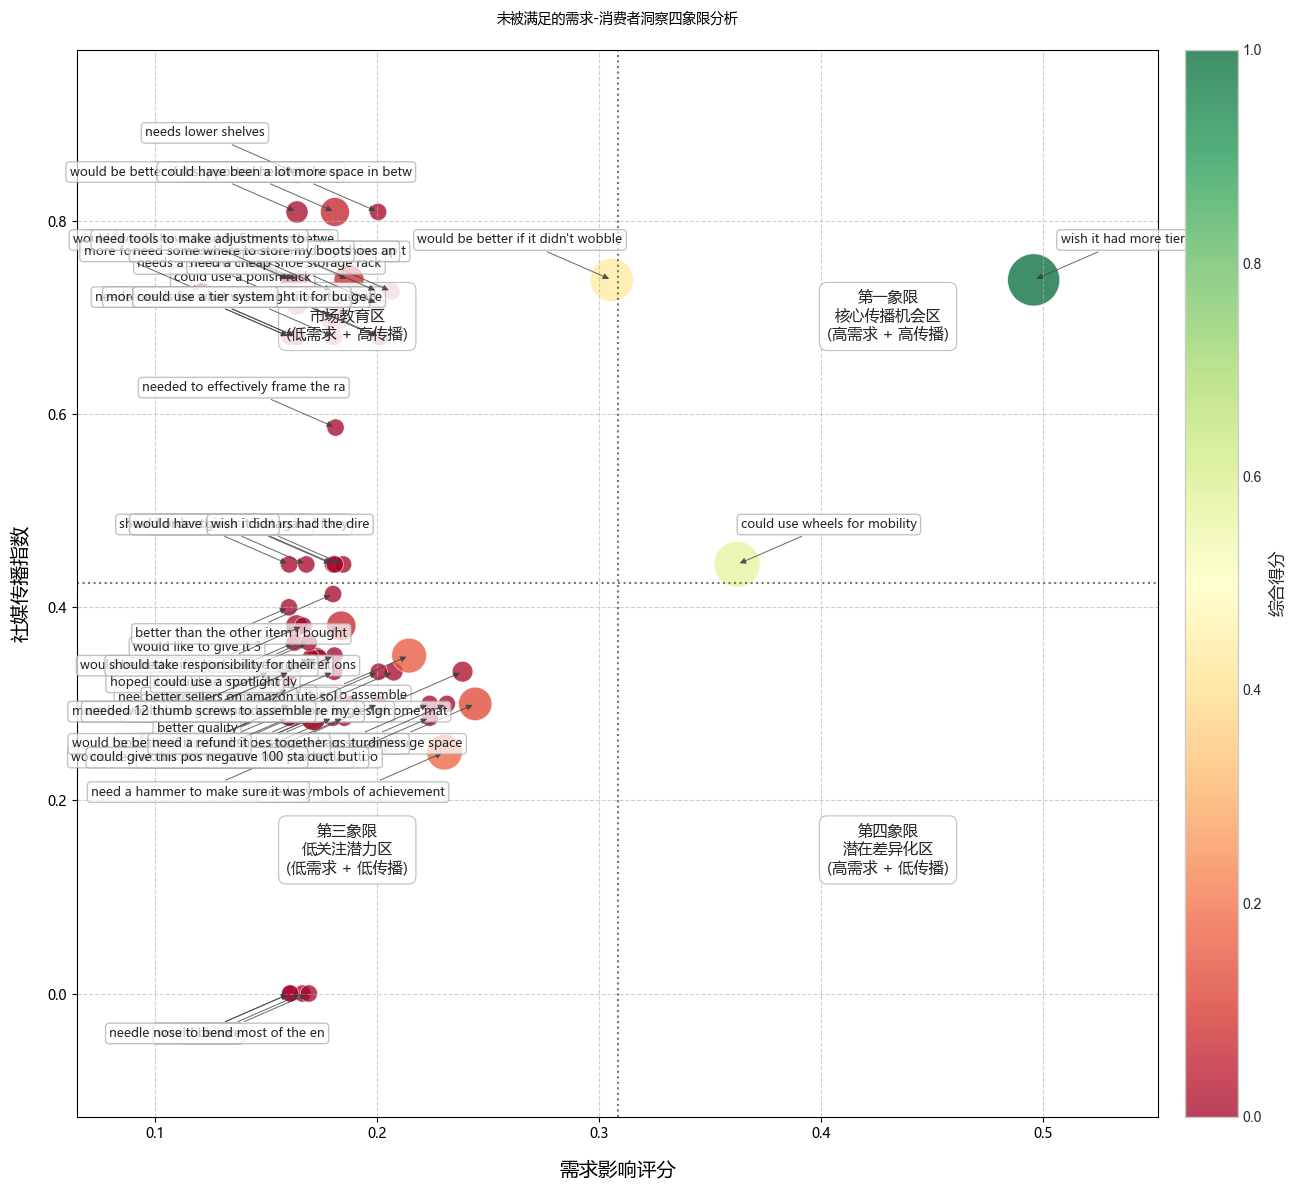

In [12]:
# --- 调用代码 ---
try:
    # 读取包含"需求"计算结果的Excel文件
    excel_path_input = os.path.join('生成结果/last_quadrant/','四象限数据-需求.xlsx')
    
    if not os.path.exists(excel_path_input):
        print(f"输入文件不存在: {excel_path_input}，可能是因为VOC数据为空")
        # 在文件不存在的情况下，创建空的DataFrame用于绘图
        empty_df = pd.DataFrame(columns=[
            '象限', '排名', '需求名称', '重要性分数', '提及频率', 
            '文本质量', '最终得分', '综合得分', '需求影响评分', '社媒传播指数'
        ])
        # 直接调用绘图函数
        plot_quadrant_chart(empty_df)
    else:
        # 正常读取数据并生成图表
        results = pd.read_excel(excel_path_input)
        print(f"成功读取数据，共 {len(results)} 条记录。")
        
        # 检查是否有实际数据点
        if len(results) == 0:
            print("警告：Excel文件存在但不包含任何数据行")
        
        # 调用绘图函数
        plot_quadrant_chart(results)
        
except Exception as e:
    print(f"执行过程中发生未知错误: {e}")
    import traceback
    traceback.print_exc()
    
    # 尝试创建空白图表作为后备方案
    print("尝试创建空白四象限图...")
    empty_df = pd.DataFrame(columns=[
        '象限', '排名', '需求名称', '重要性分数', '提及频率', 
        '文本质量', '最终得分', '综合得分', '需求影响评分', '社媒传播指数'
    ])
    try:
        plot_quadrant_chart(empty_df)
    except:
        print("创建空白图表失败")